## Edge detection per color

In [59]:
# ==============================================================================
# CELL 1: PART 1 – Edge Detection per Color (Interactive)
# ==============================================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import defaultdict

In [81]:
# ──────────────────────────────────────────────────────────────────────────────
# Global data holders
# ──────────────────────────────────────────────────────────────────────────────
loaded_image_data = {
    "original"        : None,
    "bgr_for_processing": None,   # 3‑channel BGR version
    "filename_base"   : None,
    "height"          : 0,
    "width"           : 0,
    "total_area"      : 0,
    "perimeter_ref"   : 0,
    "palette"         : None      # list of (B,G,R)
}
part1_results = {
    "contours_by_color": {},
    "combined_mask"    : None
}

# ──────────────────────────────────────────────────────────────────────────────
# Helper – load a default quantised image and palette
# ──────────────────────────────────────────────────────────────────────────────
def load_default_image(path="ppf_quant.png"):
    img = cv2.imread(path)
    if img is None:
        print(f"Could not load {path}")
        return

    palette = np.unique(img.reshape(-1, img.shape[-1]), axis=0).tolist()
    palette = [tuple(map(int, c)) for c in palette]

    loaded_image_data.update(
        original            = img,
        bgr_for_processing  = img[:, :, :3] if img.shape[2] == 4 else img,
        filename_base       = path.rsplit(".", 1)[0],
        palette             = palette,
        height              = img.shape[0],
        width               = img.shape[1],
        total_area          = float(img.shape[0] * img.shape[1]),
        perimeter_ref       = float(2 * (img.shape[0] + img.shape[1])),
    )
    print(f"Loaded {path}: {img.shape[1]}×{img.shape[0]}  "
          f"with {len(palette)} palette colours")

load_default_image()          # auto‑load on notebook start

# ──────────────────────────────────────────────────────────────────────────────
# Core – contour extraction per colour
# ──────────────────────────────────────────────────────────────────────────────
def find_contours_per_color(image_bgr, palette_colors,
                            use_morph_close, morph_ksize,
                            dedup_tau):
    """
    • Builds a binary mask for each palette colour.
    • Optional morphological closing on that mask.
    • Finds closed contours directly with cv2.findContours.
    • Removes tiny outlines and deduplicates across colours
      using shape + centroid + area criteria.
    """
    h, w = image_bgr.shape[:2]
    contours_by_color = defaultdict(list)
    combined_mask     = np.zeros((h, w), np.uint8)   # for debugging
    img_mask          = image_bgr[:, :, :3] if image_bgr.shape[2] == 4 else image_bgr
    min_area_px       = 0.01 / 100 * (h * w)         # 0.01 % of image

    for colour in palette_colors:
        mask_bool = np.all(img_mask == np.array(colour, img_mask.dtype), axis=2)
        if not mask_bool.any():
            continue
        mask_u8   = mask_bool.astype(np.uint8) * 255

        # --- remove salt‑and‑pepper specks --------------------------------
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_OPEN, kernel)

        if use_morph_close and morph_ksize > 0:
            kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_ksize, morph_ksize))
            mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_CLOSE, kernel)

        # --- remove salt‑and‑pepper specks --------------------------------
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_OPEN, kernel)

        raw, _ = cv2.findContours(mask_u8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        raw    = [c for c in raw if cv2.contourArea(c) >= min_area_px]

        if raw:
            contours_by_color[colour].extend(raw)
            combined_mask = cv2.bitwise_or(combined_mask, mask_u8)

    # ── belt‑and‑suspenders deduplication ───────────────────────────────
    if dedup_tau > 0:
        pos_tol = max(h, w) * 0.01   # 1 % of larger dimension
        area_tol = 0.10              # ±10 % area
        uniques, cleaned = [], defaultdict(list)

        def centroid(cnt):
            m = cv2.moments(cnt)
            return np.array([m["m10"], m["m01"]]) / max(m["m00"], 1e-6)

        for col, cnts in contours_by_color.items():
            for c in cnts:
                c_area, c_cent = cv2.contourArea(c), centroid(c)
                keep = True
                for u in uniques:
                    if cv2.matchShapes(c, u, cv2.CONTOURS_MATCH_I1, 0) < dedup_tau:
                        u_area, u_cent = cv2.contourArea(u), centroid(u)
                        if (np.linalg.norm(c_cent - u_cent) <= pos_tol and
                            abs(c_area - u_area) / max(c_area, u_area) <= area_tol):
                            keep = False
                            break
                if keep:
                    uniques.append(c)
                    cleaned[col].append(c)
        contours_by_color = cleaned
    # ────────────────────────────────────────────────────────────────────
    return contours_by_color, combined_mask

# ──────────────────────────────────────────────────────────────────────────────
# Visualisation  –  gallery  + hierarchy‑aware reconstruction
# ──────────────────────────────────────────────────────────────────────────────
def display_contours_per_color(contours_by_color, height, width, palette,
                               thumbs_per_row=6, thumb_scale=0.20):
    if not contours_by_color:
        print("No contours found.")
        return

    print("Total contours: ", sum(len(cnts) for cnts in contours_by_color.values()))
    img_bgr = loaded_image_data["bgr_for_processing"]
    thumb_w, thumb_h = int(width * thumb_scale), int(height * thumb_scale)

    tiles = []                                    # list to hold (title, image) tuples
    reconstructed = np.full_like(img_bgr, 255)    # white canvas for filled reconstruction
    combined_outline = np.full_like(img_bgr, 255)   # white canvas for drawn outlines

    for colour in palette:
        if colour not in contours_by_color:
            continue

        # ── 1. Create a colored mask thumbnail  ─────────────────────────────
        # Build a boolean mask from the original image that selects
        # only the pixels matching the palette color.
        mask_bool = np.all(img_bgr == np.array(colour, img_bgr.dtype), axis=2)
        # Create a blank image and fill with the palette color where mask is True.
        mask_col = np.zeros_like(img_bgr)
        mask_col[mask_bool] = colour
        mask_thumb = cv2.resize(mask_col, (thumb_w, thumb_h), cv2.INTER_NEAREST)
        # The title now includes the RGB color (reversed order from BGR)
        # and the count of distinct contours for that color.
        title_mask = f"Mask {tuple(reversed(colour))} (n={len(contours_by_color[colour])})"
        tiles.append((title_mask, mask_thumb))

        # ── 2. Create a contour (outline) thumbnail  ─────────────────────────
        canvas = np.full((height, width, 3), 255, np.uint8)
        cv2.drawContours(canvas, contours_by_color[colour], -1,
                         tuple(int(c) for c in colour), cv2.FILLED)
        cv2.drawContours(combined_outline, contours_by_color[colour], -1,
                         tuple(int(c) for c in colour), 1)
        cv_thumb = cv2.resize(canvas, (thumb_w, thumb_h), cv2.INTER_AREA)
        # This tile’s title shows the count of contours for that color.
        tiles.append((f"Contours ({len(contours_by_color[colour])})", cv_thumb))

        # ── 3. Union reconstruction without overwriting  ─────────────────────
        # create one mask per colour
        masks_by_color = {}
        areas_by_color = {}

        for colour, cnts in contours_by_color.items():
            mask_u8 = np.zeros((height, width), np.uint8)
            cv2.drawContours(mask_u8, cnts, -1, 255, cv2.FILLED)
            masks_by_color[colour] = mask_u8
            areas_by_color[colour] = int(mask_u8.sum())          # pixel count

        # start from blank white canvas
        reconstructed = np.full((height, width, 3), 255, np.uint8)

        # paint colours in descending area order so large regions win ties
        for colour, _ in sorted(areas_by_color.items(),
                                key=lambda kv: kv[1], reverse=True):
            mask = masks_by_color[colour].astype(bool)
            # paint only where the canvas is still white
            unpainted = mask & (reconstructed[:, :, 0] == 255)
            reconstructed[unpainted] = colour        # colour is already BGR tuple


    # ── 4. Show thumbnail grid  ─────────────────────────────────────────────
    cols = thumbs_per_row
    rows = math.ceil(len(tiles) / cols)
    plt.figure(figsize=(cols * 2, rows * 2))
    for idx, (title, img) in enumerate(tiles, 1):
        plt.subplot(rows, cols, idx)
        if img.ndim == 2:
            plt.imshow(img, cmap="gray")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title, fontsize=6)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    # ── 5. Combined outline  ────────────────────────────────────────────────
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(combined_outline, cv2.COLOR_BGR2RGB))
    plt.title("All Coloured Contours (outline)")
    plt.axis("off")
    plt.show()

    # ── 6. Reconstructed image  ─────────────────────────────────────────────
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
    plt.title("Reconstructed Image")
    plt.axis("off")
    plt.show()

    # store for later stages
    part1_results["reconstructed"] = reconstructed


# ──────────────────────────────────────────────────────────────────────────────
# Interactive controls (only ones we still use)
# ──────────────────────────────────────────────────────────────────────────────
w_use_morph_close = widgets.Checkbox(value=True,  description="Morph Close")
w_morph_ksize     = widgets.IntSlider(value=3, min=1, max=15, step=2,
                                      description="Kernel", continuous_update=False)
w_dedup_tau       = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.01,
                                        description="Dedup τ", continuous_update=False)

def update_part1(use_morph_close, morph_ksize, dedup_tau):
    clear_output(wait=True)
    if loaded_image_data["original"] is None:
        print("Load an image first."); return
    img   = loaded_image_data["bgr_for_processing"]
    pal   = loaded_image_data["palette"]
    h, w  = loaded_image_data["height"], loaded_image_data["width"]

    cnts_by_col, comb_mask = find_contours_per_color(
        img, pal, use_morph_close, morph_ksize, dedup_tau)

    part1_results.update(contours_by_color=cnts_by_col, combined_mask=comb_mask)
    display_contours_per_color(cnts_by_col, h, w, pal)
    print("\nPart 1 complete – proceed to Part 2 if desired.")

controls = widgets.VBox([w_use_morph_close, w_morph_ksize, w_dedup_tau])
out      = widgets.interactive_output(update_part1,
              dict(use_morph_close=w_use_morph_close,
                   morph_ksize    =w_morph_ksize,
                   dedup_tau      =w_dedup_tau))
display(widgets.HTML("<h3>Part 1 – Mask‑based Contours</h3>"), controls, out)


Loaded ppf_quant.png: 340×611  with 8 palette colours


HTML(value='<h3>Part\u202f1 – Mask‑based Contours</h3>')

Output()

In [82]:
contours = part1_results["contours_by_color"]

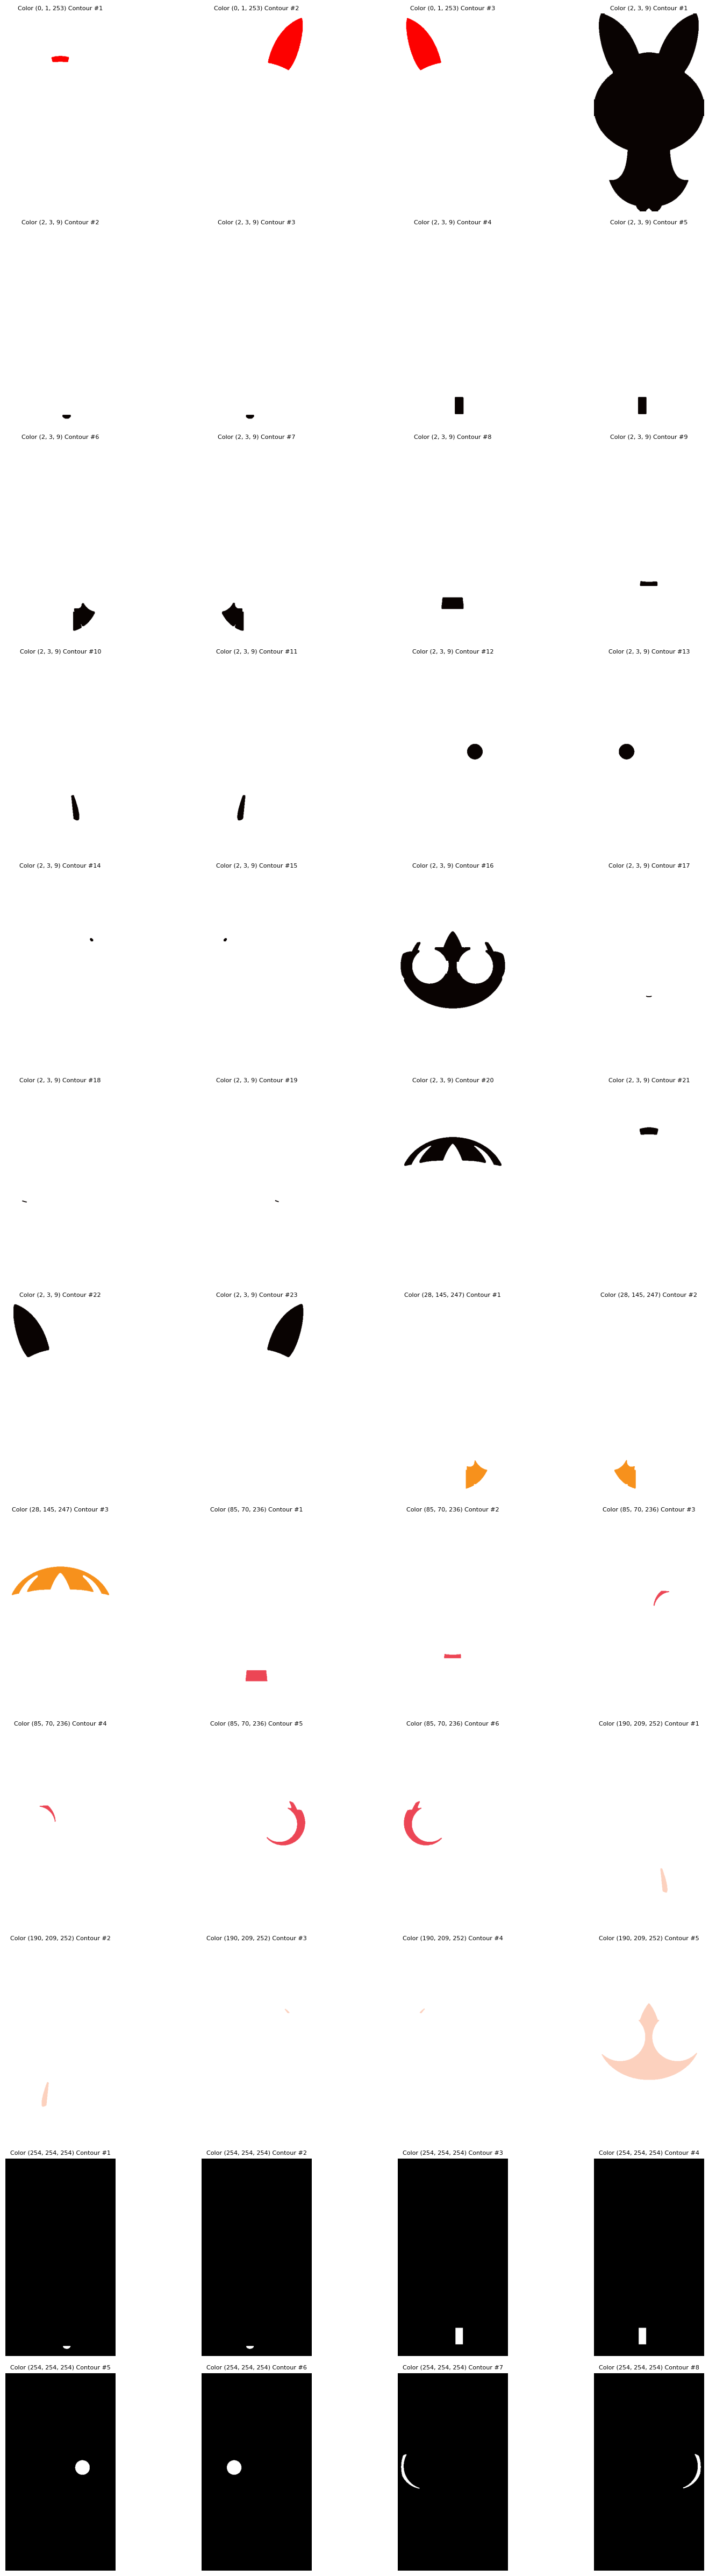

In [83]:
import matplotlib.pyplot as plt
import cv2, math, numpy as np

actual_bg_color = (255, 255, 255)

# Check that contours exist in the global part1_results dictionary.
if not part1_results.get("contours_by_color"):
    print("No contours found in part1_results['contours_by_color']. Please run Part 1 first.")
else:
    # List to store each (title, image) tuple.
    contour_images = []

    # Define a threshold to decide if a color is close to white.
    # For example, if all channels are >= 230, we consider the color to be close to white.
    white_threshold = 230

    # Iterate over each color and its contours.
    for colour, contours in part1_results["contours_by_color"].items():
        # 'colour' is in BGR. We use it as-is for drawing.
        for idx, cnt in enumerate(contours, start=1):
            # Decide on background color:
            # if the palette color is close to white, use a black background; otherwise, use white.
            if all(c >= white_threshold for c in colour):
                bg_color = (0, 0, 0)  # black background
            else:
                bg_color = (255, 255, 255)  # white background

            # Create a canvas with the same dimensions as the original image.
            if(colour != actual_bg_color):
              h, w = loaded_image_data["height"], loaded_image_data["width"]
              canvas = np.full((h, w, 3), bg_color, dtype=np.uint8)

              # Draw the contour filled with its color.
              cv2.drawContours(canvas, [cnt], -1, colour, thickness=cv2.FILLED)

              # Prepare a title showing the BGR color and contour index.
              title = f"Color {tuple(colour)} Contour #{idx}"

              contour_images.append((title, canvas))

    # Display all images on a grid.
    num_images = len(contour_images)
    cols = 4  # number of columns in the grid (adjust as needed)
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(cols * 4, rows * 4))

    for i, (title, img) in enumerate(contour_images):
        plt.subplot(rows, cols, i + 1)
        # Convert from BGR to RGB for proper display in matplotlib.
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title, fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Element summary (id → parent, depth, area, peri):
    3 →   - , d=0 , area=134286 , peri=2132
   48 →   - , d=0 , area=53 , peri=32
   49 →   - , d=0 , area=19793 , peri=863
   50 →   - , d=0 , area=19506 , peri=860
   51 →   - , d=0 , area=6454 , peri=586
   52 →   - , d=0 , area=15800 , peri=677
   53 →   - , d=0 , area=6142 , peri=586
    4 →   3 , d=1 , area=234 , peri=64
    5 →   3 , d=1 , area=228 , peri=62
    6 →   3 , d=1 , area=1348 , peri=153
    7 →   3 , d=1 , area=1298 , peri=152
    8 →   3 , d=1 , area=3327 , peri=270
    9 →   3 , d=1 , area=3358 , peri=268
   10 →   3 , d=1 , area=2268 , peri=198
   11 →   3 , d=1 , area=664 , peri=131
   12 →   3 , d=1 , area=1095 , peri=182
   13 →   3 , d=1 , area=1096 , peri=182
   14 →   3 , d=1 , area=1739 , peri=155
   15 →   3 , d=1 , area=1734 , peri=155
   16 →   3 , d=1 , area=66 , peri=31
   17 →   3 , d=1 , area=66 , peri=31
   18 →   3 , d=1 , area=32362 , peri=1613
   22 →   3 , d=1 , area=12335 , peri=1033
   23 →   3

<ipython-input-84-e80e4c5c684d>:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  depth_colors = plt.cm.get_cmap("tab10")   # 10 discrete colours


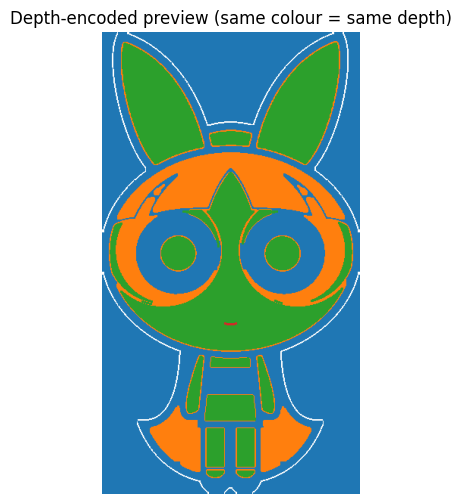

In [84]:
# ==============================================================================
# CELL N+1:  Element properties, ancestry graph, layering heuristic
# ==============================================================================

import cv2, numpy as np, matplotlib.pyplot as plt, math, pprint

# ------------------------------------------------------------------ 0. Inputs
contours_by_color = part1_results["contours_by_color"]
h, w = loaded_image_data["height"], loaded_image_data["width"]

if not contours_by_color:
    raise ValueError("Run Part 1 first – no contours found!")

# ------------------------------------------------------------------ 1. Create element list
elements = []           # list of dicts
id_map   = {}           # contour (Python id) → element dict  (for quick lookup)

for colour, cnts in contours_by_color.items():
    for cnt in cnts:
        area      = cv2.contourArea(cnt)
        peri      = cv2.arcLength(cnt, True)
        M         = cv2.moments(cnt)
        centroid  = np.array([M["m10"] / max(M["m00"], 1e-6),
                              M["m01"] / max(M["m00"], 1e-6)])   # (x,y)
        elem = dict(
            id=len(elements),       # sequential integer id
            colour=tuple(int(c) for c in colour),    # BGR
            contour=cnt,
            area=area,
            perimeter=peri,
            centroid=centroid,
            parent=None,            # to be filled
            children=[],            # list of ids
            depth=None              # to be filled
        )
        elements.append(elem)
        id_map[id(cnt)] = elem

# ------------------------------------------------------------------ 2. Detect "enveloped‑by" (closest parent)
# Pre‑cache bounding‑boxes so we don’t call cv2.boundingRect repeatedly
for e in elements:
    x, y, w_box, h_box = cv2.boundingRect(e["contour"])
    e["bbox"] = (x, y, w_box, h_box)

# For every pair (inner, outer) with outer.area > inner.area
for inner in elements:
    best_parent     = None
    best_area_diff  = float("inf")          # we’ll minimise this

    for outer in elements:
        if outer["area"] <= inner["area"]:
            continue          # parent must be strictly larger

        # --- fast bbox containment test -----------------------------------
        xo, yo, wo, ho = outer["bbox"]
        xi, yi, wi, hi = inner["bbox"]
        if (xo > xi or yo > yi or xo + wo < xi + wi or yo + ho < yi + hi):
            continue          # inner bbox not fully inside → skip quickly

        # --- precise test: inner centroid inside outer? --------------------
        if cv2.pointPolygonTest(outer["contour"],
                                tuple(inner["centroid"]), False) < 0:
            continue

        area_diff = outer["area"] - inner["area"]
        if area_diff < best_area_diff:      # found a more direct envelope
            best_area_diff = area_diff
            best_parent    = outer

    # record the closest enclosing parent (if any)
    if best_parent is not None:
        inner["parent"] = best_parent["id"]
        best_parent["children"].append(inner["id"])

# ------------------------------------------------------------------ 3. Assign depths (root = 0)
def set_depth(elem, d):
    elem["depth"] = d
    for cid in elem["children"]:
        set_depth(elements[cid], d + 1)

for elem in elements:
    if elem["parent"] is None:      # top‑level shapes
        set_depth(elem, 0)

# ------------------------------------------------------------------ 4. Layering heuristic
#    Example rule: sort by (depth    asc,    area desc)
layer_order = sorted(elements, key=lambda e: (e["depth"]))

print("Element summary (id → parent, depth, area, peri):")
for e in layer_order:
    print(f"  {e['id']:>3} → {e['parent'] if e['parent'] is not None else '-':>3} ,"
          f" d={e['depth']} , area={e['area']:.0f} , peri={e['perimeter']:.0f}")

# ------------------------------------------------------------------ 5. Quick visual check – colour‑coded by depth
depth_colors = plt.cm.get_cmap("tab10")   # 10 discrete colours
canvas = np.full((h, w, 3), 255, np.uint8)

for e in layer_order:                     # paint in layering order
    fake_color = tuple(int(c*255) for c in depth_colors(e["depth"] % 10)[:3][::-1])
    cv2.drawContours(canvas, [e["contour"]], -1, fake_color, cv2.FILLED)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Depth‑encoded preview (same colour = same depth)")
plt.axis("off")
plt.show()

# ------------------------------------------------------------------ 6. (OPTIONAL) export the 'elements' list for later use
# e.g.  with pickle / JSON, or keep it in memory for further processing.
#pprint.pprint(elements[:5])   # peek at first few entries


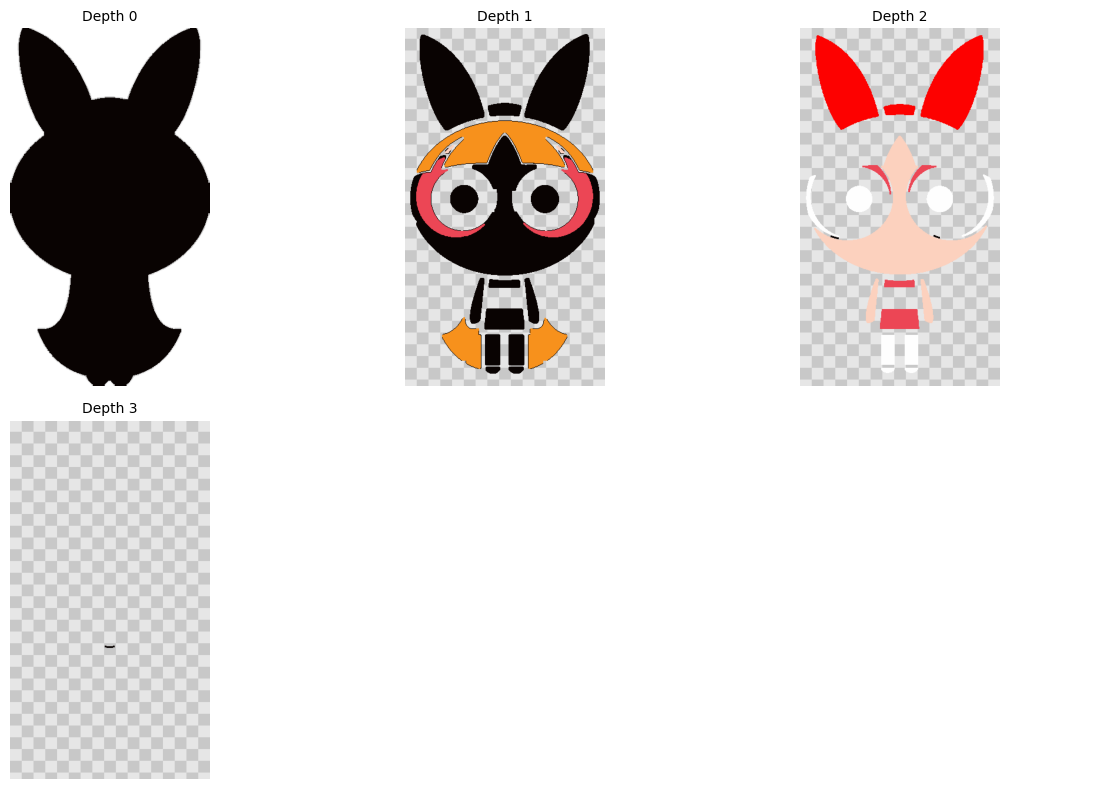

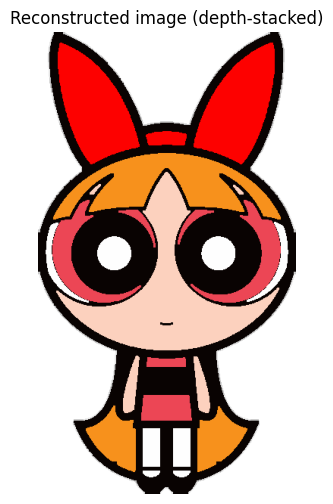

In [86]:
# ==============================================================================
# CELL N+3:  Depth previews + final reconstruction
# ==============================================================================

import cv2, numpy as np, matplotlib.pyplot as plt, math

# --- 0. Sanity checks ---------------------------------------------------------
if not elements or any(e["depth"] is None for e in elements):
    raise ValueError("Run the ancestry cell first to populate 'elements' with depth.")

h, w = loaded_image_data["height"], loaded_image_data["width"]

# --- 1. Helper – checkerboard background -------------------------------------
def make_checkerboard(height, width, block=20,
                      color_a=(230, 230, 230), color_b=(200, 200, 200)):
    yy, xx = np.indices((height, width))
    pattern = ((yy // block) + (xx // block)) % 2
    board   = np.empty((height, width, 3), np.uint8)
    board[pattern == 0] = color_a
    board[pattern == 1] = color_b
    return board

# --- 2. Create one canvas per depth ------------------------------------------
depth_levels   = sorted({e["depth"] for e in elements})
depth_canvases = []                          # list of (depth, BGR image)

for d in depth_levels:
    canvas = make_checkerboard(h, w)
    for e in elements:
        if e["depth"] == d:
            cv2.drawContours(canvas, [e["contour"]], -1, e["colour"], cv2.FILLED)
    depth_canvases.append((d, canvas))

# --- 3. Display depth previews -----------------------------------------------
cols = 3
rows = math.ceil(len(depth_canvases) / cols)
plt.figure(figsize=(cols * 4, rows * 4))

for idx, (d, img_bgr) in enumerate(depth_canvases, 1):
    plt.subplot(rows, cols, idx)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Depth {d}", fontsize=10)
    plt.axis("off")

for blank in range(idx + 1, rows * cols + 1):
    plt.subplot(rows, cols, blank); plt.axis("off")

plt.tight_layout()
plt.show()

# --- 4. Final reconstructed image (paint depth 0 → max) ----------------------
reconstructed = make_checkerboard(h, w)     # start with same checkerboard

for d in depth_levels:                      # ascending depth order
    for e in elements:
        if e["depth"] == d:
            cv2.drawContours(reconstructed, [e["contour"]], -1, e["colour"], cv2.FILLED)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed image (depth‑stacked)")
plt.axis("off")
plt.show()


In [26]:
import os
import cv2
import numpy as np

def contour_to_svg_path(cnt):
    """
    Convert a contour (numpy array of points) into an SVG 'd' path string.
    """
    # Reshape contour to an array of (x,y) points
    points = cnt.reshape(-1, 2)
    if len(points) == 0:
        return ""
    # Create path data string: Move to first point, then line-to subsequent, and close path.
    d = f"M {points[0][0]} {points[0][1]} " + " ".join(f"L {x} {y}" for x, y in points[1:]) + " Z"
    return d

def bgr_to_hex(bgr):
    """ Convert a BGR tuple (int, int, int) to a hex color string (e.g., '#rrggbb'). """
    # Reverse the order to get RGB.
    r, g, b = bgr[2], bgr[1], bgr[0]
    return f"#{r:02x}{g:02x}{b:02x}"

# Create an output folder for SVG files.
output_folder = "exported_svgs"
os.makedirs(output_folder, exist_ok=True)

# Get the image dimensions from loaded_image_data.
img_width  = loaded_image_data["width"]
img_height = loaded_image_data["height"]

# Counter for all exported files.
export_count = 0

# Iterate over each color and corresponding list of contours.
for colour, contours in part1_results.get("contours_by_color", {}).items():
    # Convert the BGR color to hex for use in SVG.
    svg_color = bgr_to_hex(colour)

    # For each contour for this palette color
    for idx, cnt in enumerate(contours, start=1):
        # Convert contour to SVG path data.
        d = contour_to_svg_path(cnt)
        # Get bounding box metadata (position & size)
        x, y, w, h = cv2.boundingRect(cnt)

        # Create metadata strings
        meta_title = f"Contour {idx} for color {colour}"
        meta_desc  = f"Bounding box: x={x}, y={y}, w={w}, h={h}; Total contours for this color: {len(contours)}"

        # Build the SVG content.
        # We include a <title> and <desc> for metadata.
        svg_content = f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg" width="{img_width}" height="{img_height}" viewBox="0 0 {img_width} {img_height}">
  <title>{meta_title}</title>
  <desc>{meta_desc}</desc>
  <path d="{d}" fill="{svg_color}" stroke="none" />
</svg>
'''
        # Create a file name using the color and contour index.
        filename = f"contour_{colour[0]}_{colour[1]}_{colour[2]}_{idx}.svg"
        filepath = os.path.join(output_folder, filename)

        # Write the SVG file.
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(svg_content)
        export_count += 1

print(f"Exported {export_count} contour SVG files to folder '{output_folder}'.")


Exported 44 contour SVG files to folder 'exported_svgs'.


## Layer estimation